# Lab: ConceptNet Ethics Testing

- completed by: Sanjay Dubey

- With increasing recommender systems, automated hiring models, bot application and language translation models, we would need system to be fair, equal and just when using decision, recommendation and selection regarding any entity. The GloVe embedding is created by crawling on the news dataset written from perspective of a human and there might be chance that certain relevant text to exhibit likeness towards certain entity. However, as there are few relevant data available and this lacking factor forces to utilise Glove, care has been taken to make the distance vector avoid any bias but they inherit certain bias which might exist in society. 


- According to the Bolukbasi et al., word embeddings learnt from huge text datasets might display gender preconceptions and biases, such as identifying terms like "nurse" and "teacher" with female gender and words like "programmer" and "engineer" with male gender. Machine learning models that employ these embeddings may have downstream consequences as a result of these biases, potentially reinforcing gender stereotypes and resulting in discrimination. Negative effects on diversity and inclusion may result from gender bias in natural language processing, which can result in unjust treatment of individuals and the reinforcement of stereotypes.NLP models propagate and may even amplify gender bias found in text corpora.[2]


- Can the use of gender-neutral training data enhance accuracy and lessen gender bias when using an LSTM model to integrate gloves?Our study evolve more around using advance deep learning model trained to learn differentiation between three labels. It is assumed that including neutral in gender while training model could lead to update model in a way to reduce biases toward certain gender. 


- By include gender-neutral training data, the LSTM model for glove embedding will perform better and exhibit less gender bias.


- Method: We will train and test an LSTM model on a dataset including gendered data of three types—male, female, and neutral—in order to provide an answer. Using measures like accuracy, recall, F1-score, and bias metrics we will evaluate the performance and gender bias of the model trained with neutral gender data. Ultimately we will perform one way ANOVA test to conclude if there is bias in model towards certain label.



In [532]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn
import re
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding

In [2]:
# Configure how graphs will show up in this notebook
%matplotlib inline
seaborn.set_context('notebook', rc={'figure.figsize': (10, 6)}, font_scale=1.5)

In [715]:
%%time

def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    embedding={}
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            embedding[items[0]]=np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f'), embedding

embeddings, embedding_dict_glove = load_embeddings('glove.840B.300d.txt')
embeddings.shape

CPU times: user 3min 22s, sys: 25.4 s, total: 3min 48s
Wall time: 5min 19s


(2196017, 300)

In [716]:
embeddings_numberbatch, embedding_dict_numberbatch = load_embeddings('numberbatch-en.txt')
embeddings_numberbatch.shape

(417194, 300)

In [717]:
%%time

def gender_file(filename, embedding):
    """
    Load a DataFrame/Dictionary from the json format file containing data
    three type of gender and word associated with it.
    LINK: https://github.com/ecmonsen/gendered_words
    
    CITATION:
    Christiane Fellbaum (1998, ed.) 
    WordNet: An Electronic Lexical Database. Cambridge, MA: MIT Press.
    
    Dataset is derived from WordNet.
    """
    gender_dict={}
    sentences = []
    targets = []
    label=[]
    # load gendered_words
    with open(filename, 'r', encoding='utf-8') as f:
        gendered_words = json.load(f)
        #inputs: sentences and targets:gender categories
    for d in gendered_words:
        if d['word'] in embedding.keys():
            if d['gender']=='m':
                label.append(0)
                sentences.append(d['word'])
                gender_dict[d['word']]=0
                targets.append(d['gender'])
            if d['gender']=='f':
                label.append(1)
                sentences.append(d['word'])
                targets.append(d['gender'])
                gender_dict[d['word']]=2
            if d['gender']=='n':
                label.append(2)
                sentences.append(d['word'])
                targets.append(d['gender'])
                gender_dict[d['word']]=3
    return sentences, targets, label, gender_dict

gender_data = gender_file('gender.json', embedding_dict_glove)
sentences, label, targets, gender_dict=gender_data

CPU times: user 32.3 ms, sys: 95 ms, total: 127 ms
Wall time: 509 ms


In [721]:
#con
gender_data_nb = gender_file('gender.json',embedding_dict_numberbatch)
sentences_nb, label_nb, targets_nb, gender_dict=gender_data_nb

Due to large number of the words in numberbatch, we could observe that 6617 similar word matches with gender json file

In [465]:
#Parameters
max_len=50
NUM_CLASSES=3
found_words = 0
EMBED_SIZE=300
input_length=50
trainable=False

When discrete data, such words or tokens, need to be translated into continuous vector representations in an embedding space, an embedding matrix/weight matrix is used. Typically, words used in natural language processing are represented as vectors in an embedding space, and words with related meanings are mapped to nearby vectors. It contains vectors of 300 dim of the words that matches in the GloVe or numberbatch files. The semantic connections between words that are discovered during the training of the embedding matrix can be used by the model which require pre-trained embedding matrix.

In [729]:
def generate_token(sentences,max_len,targets, num_classes, found_words, embedding):
    ''''
    sentences: word in the gendered_file
    tokenize generate index for each word 
    padding does not use post method which basically adds zeroes at the end.
    max_len of 50 is used which represent size of the input string
    ''''
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    word_index = tokenizer.word_index
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    targets = tf.keras.utils.to_categorical(targets, num_classes)
        #  keras word tokenizer from before
    embedding_matrix = np.zeros((len(word_index)+1, EMBED_SIZE))
    for word, i in word_index.items():
        embedding_vector = embedding.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be ALL-ZEROS
            embedding_matrix[i] = embedding_vector
            found_words = found_words+1

    print("Embedding Shape:",embedding_matrix.shape, "\n",
          "Total words found:",found_words, "\n",
          "Percentage:",100*found_words/embedding_matrix.shape[0])
    return padded_sequences, targets, word_index, embedding_matrix
X,y, word_index, embedding_matrix=generate_token(sentences,max_len,targets, NUM_CLASSES, found_words, embedding_dict_glove)

Embedding Shape: (4298, 300) 
 Total words found: 4295 
 Percentage: 99.93020009306655


In [731]:
#u
X_nb,y_nb, word_index_nb, embedding_matrix_nb=generate_token(sentences_nb,max_len,targets_nb, NUM_CLASSES, found_words, embedding_dict_numberbatch)

Embedding Shape: (5601, 300) 
 Total words found: 5573 
 Percentage: 99.50008926977326


- Tokenizer converts text data or string to index which are then padded to a fixed length. 
- Target variable contains lables:
    - m representing male
    - f representing female
    - n representing neutral
    - target is one hot encoded
    
- embedding is of the (5601, 300) [numberbatch] and (4298, 300) for glove embedding. The difference is due to removal of the words not found in respective word embedding.
- Dropout of 0.2 and Early stopping is included with patience of 5 to prevent overfitting. It stops the training process in case there is no improvement in validation loss.
- As problem is multiclass, categorical_crossentropy is used to measure error between true and predicted value and softmax as activation function.

In [780]:
def modelLstm(word_index,EMBED_SIZE, embedding_matrix, input_length, NUM_CLASSES ):
    
    # save this embedding now
    embedding_layer = Embedding(len(word_index)+1,
                                EMBED_SIZE,
                                weights=[embedding_matrix],# here is the embedding getting saved
                                input_length=input_length,
                                trainable=False)
    rnn = Sequential()
    rnn.add(embedding_layer)
    rnn.add(LSTM(64,dropout=0.2, recurrent_dropout=0.2))

    rnn.add(Dense(NUM_CLASSES, activation='softmax'))
    rnn.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    return rnn

- here we created model, it contain word_index of the length of words that matches in corresponding glove or numberbatch file. Embedding length is 300 which represent size of the vectors store within these files. As highlighted above, embedding_matrix is weights and learnable parameter. Due to capacity of our MacBook Pro, we added earlystopping to avoid overfitting. This would produce diminishing gradient and we can avoid over training.

- Numberbatch[numberbatch-17.06.txt.gz]: Modelling and Training 

In [781]:
lstm_numberbatch=modelLstm(word_index_nb, EMBED_SIZE, embedding_matrix_nb, input_length, NUM_CLASSES )

In [782]:
lstm_numberbatch.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 50, 300)           1680300   
                                                                 
 lstm_16 (LSTM)              (None, 64)                93440     
                                                                 
 dense_18 (Dense)            (None, 3)                 195       
                                                                 
Total params: 1,773,935
Trainable params: 93,635
Non-trainable params: 1,680,300
_________________________________________________________________


In [783]:
def train_model(X, y, model):
    
    history = []
    # Split it into train / test subsets
    X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y, test_size=0.2,
                                                            stratify=y, 
                                                            random_state=42)
    
    tmp = model.fit(X_train, y_train_ohe, validation_split=0.2, epochs=25, batch_size=32, callbacks=[stopping])
    history.append(tmp)
    return history, X_train, X_test, y_train_ohe, y_test_ohe

In [784]:
history_numberbatch, X_train, X_test, y_train_ohe, y_test_ohe=train_model(X_nb,y_nb,lstm_numberbatch)

Epoch 1/25
133/133 [==============================] - 6s 37ms/step - loss: 0.5440 - accuracy: 0.8484 - val_loss: 0.4127 - val_accuracy: 0.8659
Epoch 2/25
133/133 [==============================] - 5s 37ms/step - loss: 0.3981 - accuracy: 0.8661 - val_loss: 0.3284 - val_accuracy: 0.8839
Epoch 3/25
133/133 [==============================] - 5s 35ms/step - loss: 0.3314 - accuracy: 0.8890 - val_loss: 0.2785 - val_accuracy: 0.9103
Epoch 4/25
133/133 [==============================] - 5s 35ms/step - loss: 0.2939 - accuracy: 0.9055 - val_loss: 0.2585 - val_accuracy: 0.9169
Epoch 5/25
133/133 [==============================] - 5s 35ms/step - loss: 0.2685 - accuracy: 0.9119 - val_loss: 0.2480 - val_accuracy: 0.9235
Epoch 6/25
133/133 [==============================] - 5s 35ms/step - loss: 0.2518 - accuracy: 0.9159 - val_loss: 0.2391 - val_accuracy: 0.9207
Epoch 7/25
133/133 [==============================] - 5s 35ms/step - loss: 0.2423 - accuracy: 0.9178 - val_loss: 0.2418 - val_accuracy: 0.9263

- Modelling and training for GloVe [glove.840B.300d.txt]

In [788]:
lstm_model=modelLstm(word_index,EMBED_SIZE, embedding_matrix, input_length, NUM_CLASSES )

In [789]:
lstm_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 50, 300)           1289400   
                                                                 
 lstm_17 (LSTM)              (None, 64)                93440     
                                                                 
 dense_19 (Dense)            (None, 3)                 195       
                                                                 
Total params: 1,383,035
Trainable params: 93,635
Non-trainable params: 1,289,400
_________________________________________________________________


In [790]:
history_glove, X_train_nb, X_test_nb, y_train_nb, y_test_nb=train_model(X,y,lstm_model)

Epoch 1/25
100/100 [==============================] - 5s 39ms/step - loss: 0.4944 - accuracy: 0.8444 - val_loss: 0.3295 - val_accuracy: 0.8816
Epoch 2/25
100/100 [==============================] - 3s 35ms/step - loss: 0.2883 - accuracy: 0.8970 - val_loss: 0.2565 - val_accuracy: 0.8892
Epoch 3/25
100/100 [==============================] - 3s 35ms/step - loss: 0.2356 - accuracy: 0.9169 - val_loss: 0.2582 - val_accuracy: 0.8929
Epoch 4/25
100/100 [==============================] - 3s 35ms/step - loss: 0.2145 - accuracy: 0.9257 - val_loss: 0.2612 - val_accuracy: 0.8967
Epoch 5/25
100/100 [==============================] - 3s 35ms/step - loss: 0.1946 - accuracy: 0.9263 - val_loss: 0.2327 - val_accuracy: 0.9018
Epoch 6/25
100/100 [==============================] - 4s 35ms/step - loss: 0.1748 - accuracy: 0.9345 - val_loss: 0.2406 - val_accuracy: 0.9030
Epoch 7/25
100/100 [==============================] - 3s 35ms/step - loss: 0.1625 - accuracy: 0.9395 - val_loss: 0.2422 - val_accuracy: 0.9005

Model was run for 40 epochs and performs well on training data with training accuracy of 98%, it was able minimize loss on training data. It started with validation accuracy of 89.70% with peak of 92.36%, after certain epoch there is not much improvement in percentage implying the nedd for data augmentation technique or requirement of large set of data. we tried to decrease network size and increase output in an attempt to stimulate learning on validation set. We will try to implement early stopping in an attempt to combat the overfitting issue.

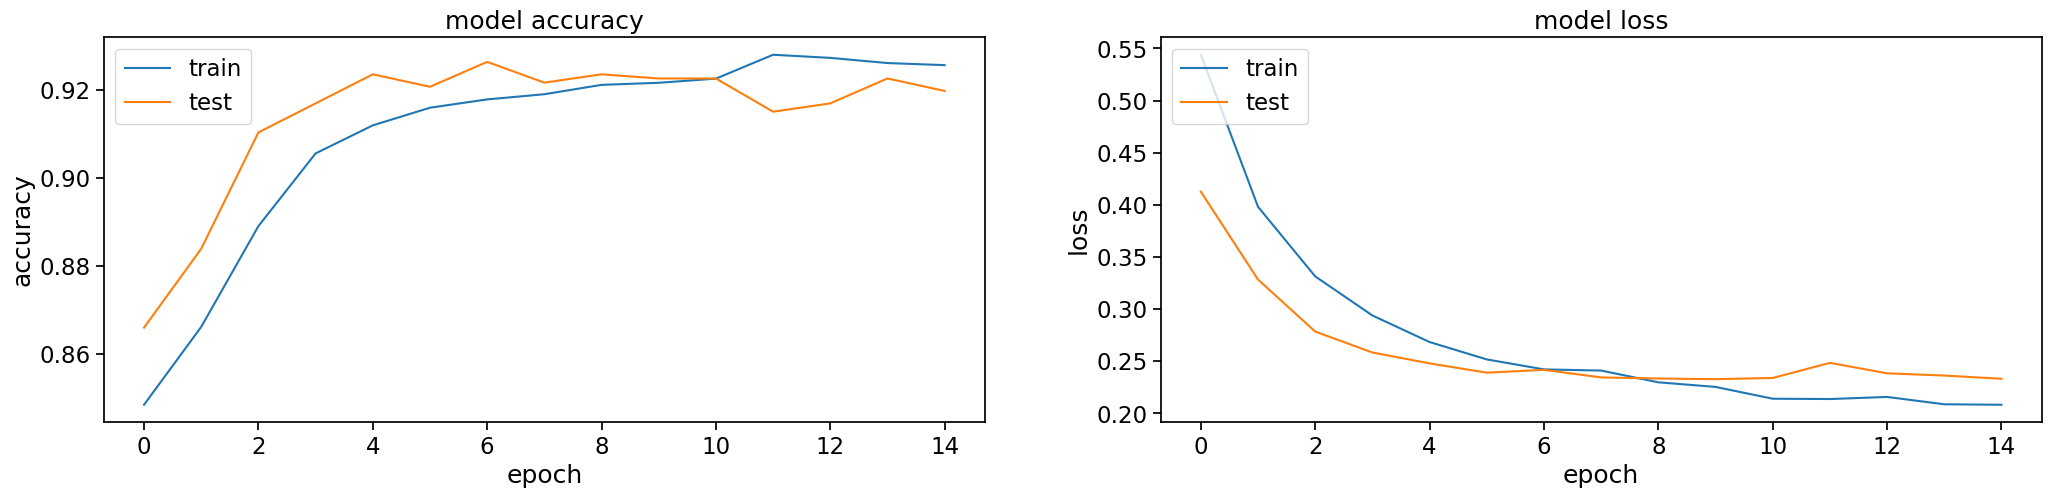

In [785]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# combine all the history from training together
combined = dict()
for key in ['accuracy','val_accuracy','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history_numberbatch])
    
# summarize history for accuracy
plt.figure(figsize=(25,5))
plt.subplot(121)
plt.plot(combined['accuracy'])
plt.plot(combined['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

- Visual for LSTM using GloVe

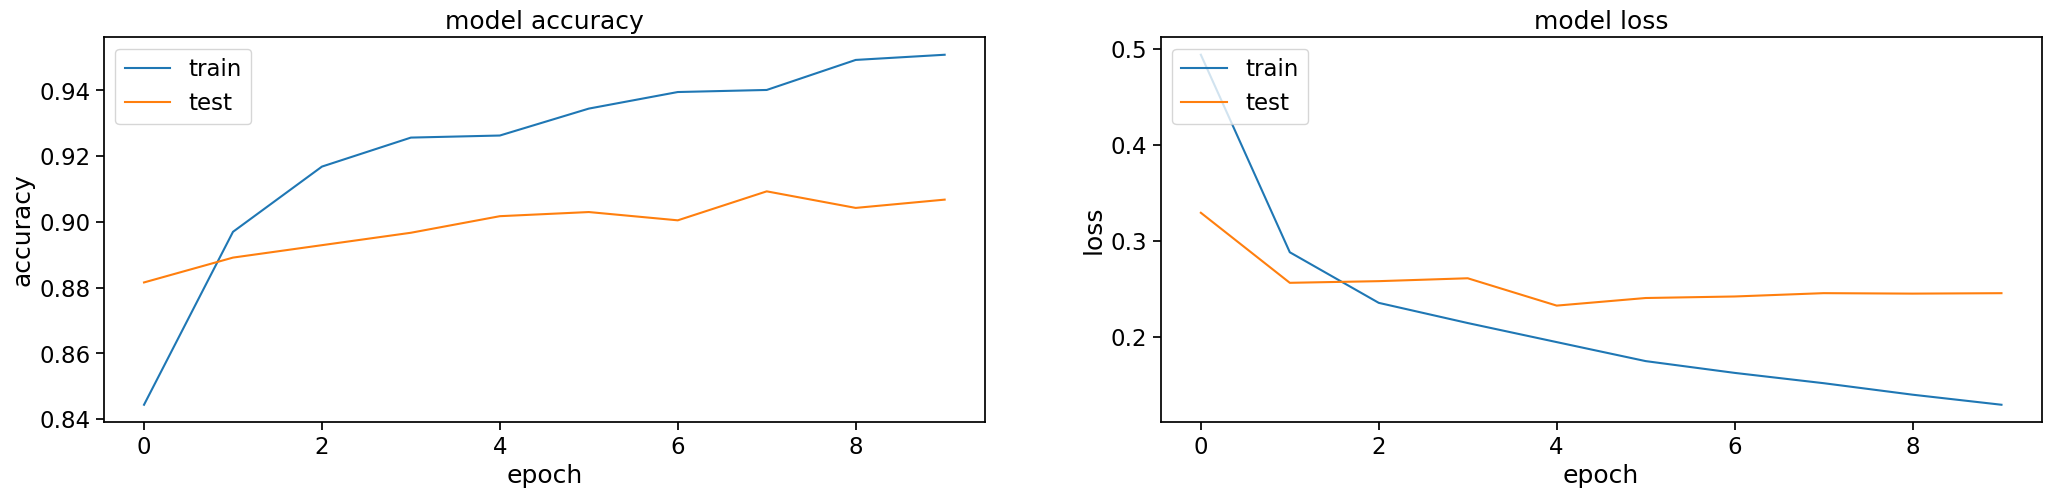

In [791]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# combine all the history from training together
combined = dict()
for key in ['accuracy','val_accuracy','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history_glove])
    
# summarize history for accuracy
plt.figure(figsize=(25,5))
plt.subplot(121)
plt.plot(combined['accuracy'])
plt.plot(combined['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

- It looks like we did good on training data but after some point model accuracy does not improve much on validation data. We observe using numberbacth text file model was able to generalize and we could see model performing in a similar fashion on test and train set. performance for 15 eochs, loss: 0.2083 - accuracy: 0.9256 - val_loss: 0.2333 - val_accuracy: 0.9197
- while model using glove embedding reaches maximum accuracy within few epochs, it was able to converse nicely on train set but that was not the case with validation. performance does not improve much after 91%, it might be overfitting or other case maybe these models are data hungry and 4700 could quite few number for it.Performance using GloVe, 10 apochs: - loss: 0.1293 - accuracy: 0.9509 - val_loss: 0.2457 - val_accuracy: 0.9068

In [1000]:
from sklearn.metrics import confusion_matrix

In [1005]:
def prediction_lstm(data, target, model):
    test_data=[]
    y_pred=model.predict(data)
    y_pred_proba = np.squeeze(y_pred)
    y_pred_log_proba = np.log(y_pred_proba / (1 - y_pred_proba))
    # Evaluate LSTM model on validation data
    score, acc = model.evaluate(data, target, batch_size=32)
        # Convert probabilities to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)
    for i in target:
        test_data.append(np.argmax(i))
    # Calculate the performance metrics
    accuracy = accuracy_score(test_data, y_pred_labels)
    precision = precision_score(test_data, y_pred_labels, average='weighted')
    recall = recall_score(test_data, y_pred_labels, average='weighted')
    f1 = f1_score(test_data, y_pred_labels, average='weighted')
    auc_roc = roc_auc_score(test_data, y_pred, multi_class='ovr')
    cm=confusion_matrix(test_data, y_pred_labels)
    texts=tokenizer.sequences_to_texts(data)
    # Print the performance metrics
    print("confusion matrix:")
    print(cm)
    print('Accuracy: {:.4f}'.format(accuracy))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1-score: {:.4f}'.format(f1))
    print('AUC-ROC: {:.4f}'.format(auc_roc))
    print('Validation accuracy:', acc)
    # Plot the ROC curves
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(target[:, i], y_pred[:, i])
        roc_auc[i] = roc_auc_score(target[:, i], y_pred[:, i])

    plt.figure(figsize=(8, 6))
    for i in range(2):
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = {:.2f})'.format(roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return texts, test_data, y_pred_labels, y_pred_proba, y_pred_log_proba
    
    
    

- Evaluations for numberbatch

42/42 [==============================] - 0s 8ms/step - loss: 0.2497 - accuracy: 0.9162
confusion matrix:
[[  42    1   70]
 [   2   58   16]
 [  15    7 1113]]
Accuracy: 0.9162
Precision: 0.9070
Recall: 0.9162
F1-score: 0.9062
AUC-ROC: 0.9260
Validation accuracy: 0.9161631464958191


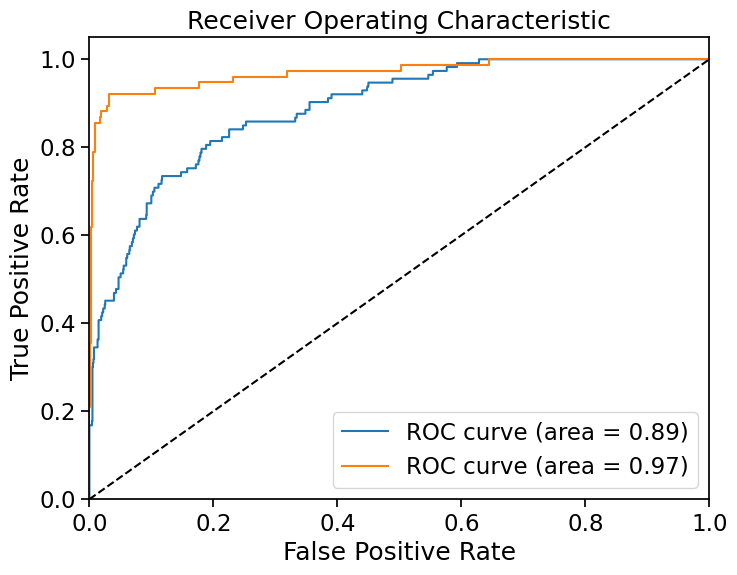

In [1006]:
texts,original_target, prediction_label, probability, log_probability= prediction_lstm(X_test, y_test_ohe, lstm_numberbatch)

- There appear to be better chance for the model, around 97%, on trained set to be able to distinguish between different labels, with area under curve of 92% and validation accuracy of 91.6%, it might be good model and with model data and learning, it might be able generalize enoguh to improve performance but that might depend on the type of the work that we are looking for.

- Evaluation for GloVe

32/32 [==============================] - 0s 8ms/step - loss: 0.2309 - accuracy: 0.9215
confusion matrix:
[[ 45   2  35]
 [  0  44  11]
 [ 22   8 826]]
Accuracy: 0.9215
Precision: 0.9172
Recall: 0.9215
F1-score: 0.9187
AUC-ROC: 0.9416
Validation accuracy: 0.921450138092041


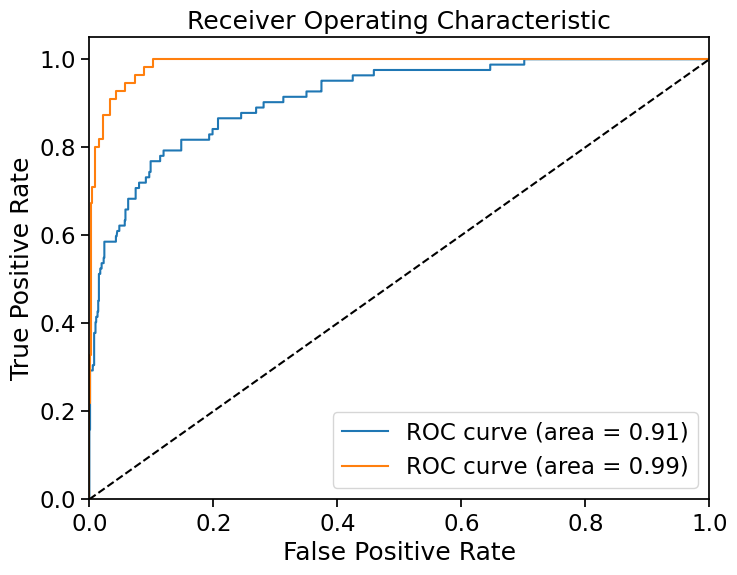

In [1007]:
texts_nb,original_target_nb, prediction_label_nb, probability_nb, log_probability_nb= prediction_lstm(X_test_nb, y_test_nb, lstm_model)

- AUC score of 94% on model using GloVe appear to be better than numberbatch and with validation accuracy of 92% could be better model than ealier if we are only comparing auc score. It appear to be better model in differentiating between different label.

- Dataframe to show performance of model's prediction with original targets by LSTM model based on numberbatch

In [834]:
results_df = pd.DataFrame({'sentence': texts, 
                           'predicted_gender': log_probability[:,0],
                           'predicted_gender_female': log_probability[:, 1], 
                           'predicted_gender_others': log_probability[:, 2], 
                           'orginial': original_target, 'predicted_target': prediction_label})
results_df.head()



,sentence,predicted_gender,predicted_gender_female,predicted_gender_others,orginial,predicted_target
0,tither,-4.586945,3.144808,-3.435144,1,1
1,canary,-3.587887,-3.611107,2.878567,2,2
2,flibbertigibbet,-4.370763,-6.780233,4.282612,2,2
3,salesclerk,-1.410585,-2.765401,1.070203,2,2
4,hygienist,-2.217990,-6.144230,2.194031,2,2


- Dataframe to show performance of model's prediction with original targets by LSTM model based on GloVe

In [838]:
results_glove = pd.DataFrame({'sentence': texts_nb, 
                           'predicted_gender': log_probability_nb[:,0],
                           'predicted_gender_female': log_probability_nb[:, 1], 
                           'predicted_gender_others': log_probability_nb[:, 2], 
                           'orginial': original_target_nb, 'predicted_target': prediction_label_nb})
results_glove.head()



,sentence,predicted_gender,predicted_gender_female,predicted_gender_others,orginial,predicted_target
0,attendant,-5.155845,-3.492128,3.308829,2,2
1,manchu,-1.737720,-9.310371,1.737008,2,2
2,jacobin,-5.649894,-7.513620,5.504769,2,2
3,employable,-6.178086,-8.954807,6.117445,2,2
4,levantine,-6.918646,-6.744467,6.133545,2,2


- Testing both methodology of using LSTM on gendered data using GloVe embedding and numberbatch. We employed mcnemar test to test if their predictions are significantly different.Null hypothesis would be that both model are similar, alternative hypothesis would be to cthat their performance are different with mean. If the calculated p value is less than level of significance we can reject null hypothesis and conclude that there issignificant difference between the two model. 

- McNemar test for lstm model using numberbatch and GloVe embedding.

In [1095]:
from statsmodels.stats.contingency_tables import mcnemar
def mcnemar_test(true_labels,model1_label, model2_label):

    #we require contingency table
    #Compute McNemar's
    table = np.zeros((3, 2))
    for i in range(len(true_labels)):
        if true_labels[i] == model1_label[i]:
            if true_labels[i] == 0:
                table[0, 0] += 1
            elif true_labels[i] == 1:
                table[1, 0] += 1
            elif true_labels[i] == 2:
                table[2, 0] += 1
        elif true_labels[i] == model2_label[i]:
            if true_labels[i] == 0:
                table[0, 1] += 1
            elif true_labels[i] == 1:
                table[1, 1] += 1
            elif true_labels[i] == 2:
                table[2, 1] += 1
    print(table)
    result= mcnemar(table)
    print('p-value: {:.14f}'.format(result.pvalue))
    print('Statistic: {:.2f}'.format(result.statistic))

In [1097]:
mcnemar_test(test_data,prediction_label,prediction_label_nb )

[[  2.  44.]
 [  3.  41.]
 [768.  85.]]
p-value: 0.00000000024647
Statistic: 3.00


- As p-value: 0.00000000024647 is less than 0.05 which is level of significatnce, we can reject null hypothesis.

- Alternate measure to calculate similarity of a word to pairs as mentioned in the paper[caliskan et al.]

In [1111]:
from scipy.spatial.distance import cosine

def cosine_similarity(word1, word2, word_to_map):
    v1 = word_to_map[word1]
    v2 = word_to_map[word2]
    return 1 - cosine(v1, v2)
#Calculate cosine similarity
s_male = cosine_similarity('he', 'him', embedding_dict_glove)
s_female = cosine_similarity('she', 'her', embedding_dict_glove)
s_neutral = cosine_similarity('they', 'table', embedding_dict_glove)

print('    male pronouns:', s_male)
print('    female pronouns:', s_female)
print('    neutral pronouns:', s_female)

    male pronouns: 0.8275200128555298
    female pronouns: 0.8436362147331238
    neutral pronouns: 0.8436362147331238


In [1112]:
from scipy.spatial.distance import cosine

print("cosine similarity for numberbatch:")
s_male = cosine_similarity('he', 'him', embedding_dict_numberbatch)
s_female = cosine_similarity('she', 'her', embedding_dict_numberbatch)
s_neutral = cosine_similarity('they', 'table', embedding_dict_numberbatch)

print('    male pronouns:', s_male)
print('    female pronouns:', s_female)
print('    neutral pronouns:', s_female)

cosine similarity for numberbatch:
    male pronouns: 0.8304474949836731
    female pronouns: 0.7889381051063538
    neutral pronouns: 0.7889381051063538


In [1113]:
def BiasEvaluation(data, model, target):
    #list of m,n,f
    male_data=[]
    female_data=[]
    neutral_data=[]
    for i in range(len(data)):
        if np.argmax(target[i])==0:
            male_data.append(data[i])
        if np.argmax(target[i])==1:
            female_data.append(data[i])
        if np.argmax(target[i])==2:
            neutral_data.append(data[i])
            
    #http://pytolearn.csd.auth.gr/d1-hyptest/12/anova-one.html
    #predict each target group; m,n,f
    male_predict = model.predict(np.array(male_data))
    male_predict = np.argmax(male_predict, axis=1)
    female_predict = model.predict(np.array(female_data))
    female_predict = np.argmax(female_predict, axis=1)
    neutral_predict = model.predict(np.array(neutral_data))
    neutral_predict = np.argmax(neutral_predict, axis=1)
    #Calculate the accuracy for each target group
    male_acc = np.mean(male_predict == 0)
    female_acc = np.mean(female_predict == 1)
    neutral_acc = np.mean(neutral_predict == 2)
    
    #mean accuracy for each group
    male_mean_acc = np.mean(male_acc)
    female_mean_acc = np.mean(female_acc)
    neutral_mean_acc = np.mean(neutral_acc)
    
    
    #one-way ANOVA test for determining statistically significant difference in accuracy between the targets
    f, p = f_oneway(male_predict, female_predict, neutral_predict)
    print()
    if p < 0.05:
        print(f'p-test score: {f}, \nF-test result: {p}. ')
    else:
        print(f'p-test score: {f}, \nF-test result: {p}.')
    
    # print results
    print("Male mean accuracy:", male_mean_acc)
    print("Female mean accuracy:", female_mean_acc)
    print("Neutral mean accuracy: ", neutral_mean_acc)

    # Create a bar plot of the accuracy for each target group
    x = ['Male', 'Female', 'Neutral']
    y = [male_acc, female_acc, neutral_acc]
    
    plt.figure(figsize=(20,10))
    plt.bar(x, y)
    plt.ylim(0, 1)
    plt.ylabel('Accuracy')
    plt.title('Accuracy by Different label/Target')
    plt.show()
    
    

- Measure one way ANOVA to determine statistical difference between each predicted type of target. If less than 0.05 we reject null hypothesis and would conduct statistical difference exist between different labels.

- ANOVA : GloVe 

27/27 [==============================] - 0s 8ms/step

p-test score: 290.77832377163855, 
F-test result: 4.5295131755931863e-100. 
Male mean accuracy: 0.5487804878048781
Female mean accuracy: 0.8
Neutral mean accuracy:  0.9649532710280374


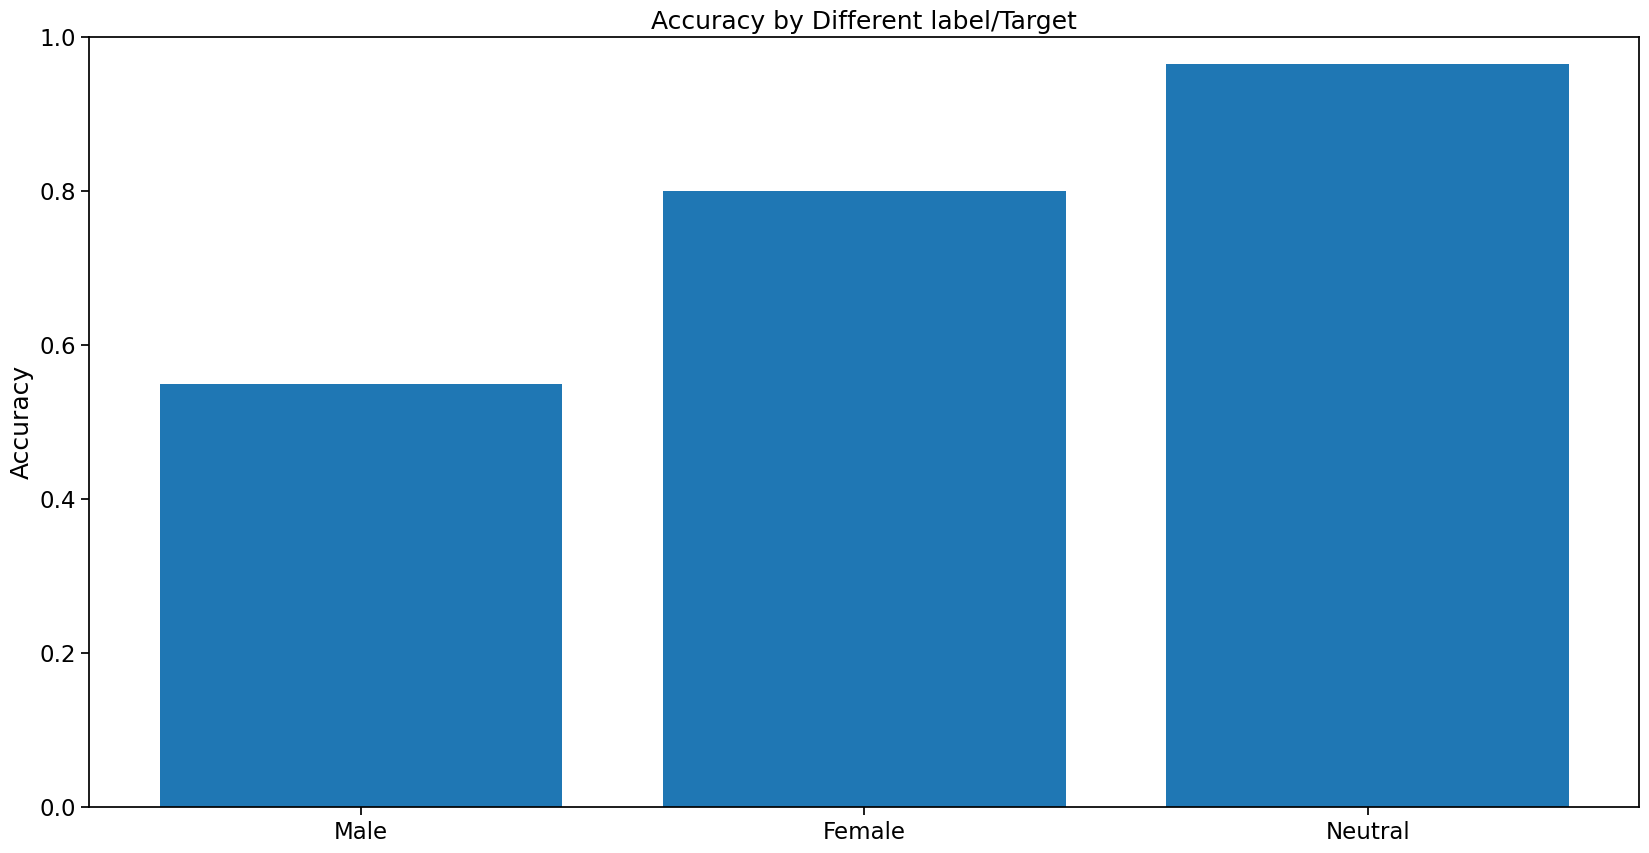

In [1114]:
BiasEvaluation(X_test_nb, lstm_model, y_test_nb)

- ANOVA : GloVe 

36/36 [==============================] - 0s 8ms/step

p-test score: 319.66137811899785, 
F-test result: 5.942148626095867e-114. 
Male mean accuracy: 0.37168141592920356
Female mean accuracy: 0.7631578947368421
Neutral mean accuracy:  0.9806167400881057


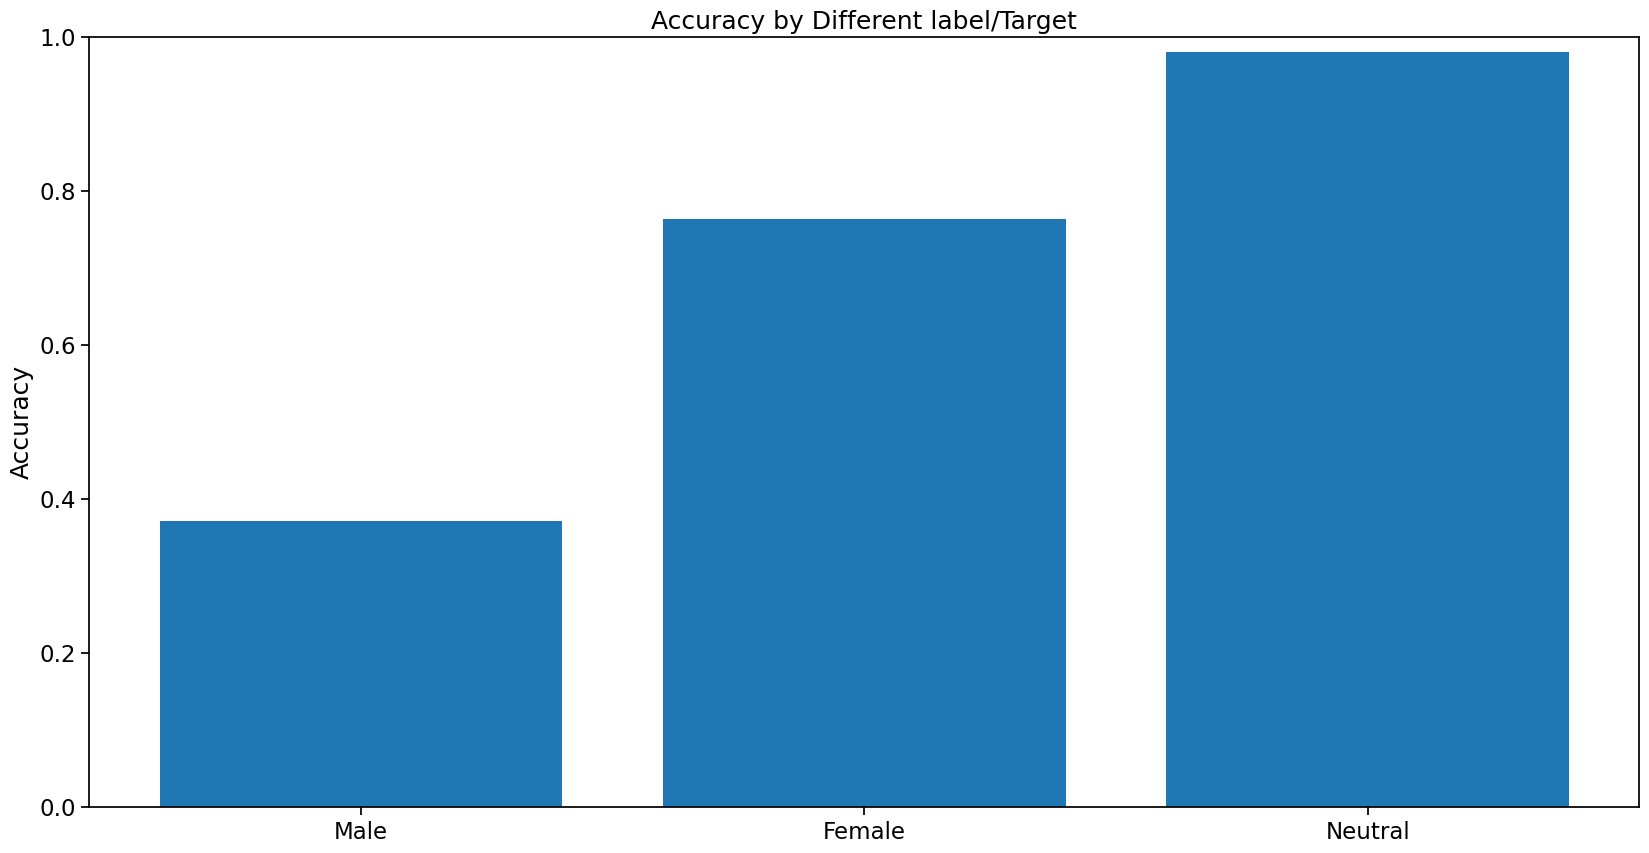

In [1115]:
BiasEvaluation(X_test, lstm_numberbatch, y_test_ohe)

- Therefore we reject null hypothesis that training lstm model with neutral as gender can improve performance to reduce gender bias. As the model was trained with dissimilarity in distribution of each targets, neutral words were more then female and male, model was able to classify neutral words effectively.

In [981]:
def biasEval(data, model, target):
    #predict for target group
    predictions = model.predict(data)
    
    
    #bias score for each word
    male_pro = predictions[:, 0]
    female_pro = predictions[:, 1]
    neutral_pro = predictions[:, 2]
    
    bias_scores = np.log2((female_pro + 1e-10) / (male_pro + 1e-10))
    
    #bias scores for each word
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20,10))
    plt.hist(bias_scores, bins=50)
    plt.xlabel('Bias score')
    plt.ylabel('Frequency')
    plt.show()
    
    

- Plot for bias scores: GloVe

32/32 [==============================] - 0s 9ms/step


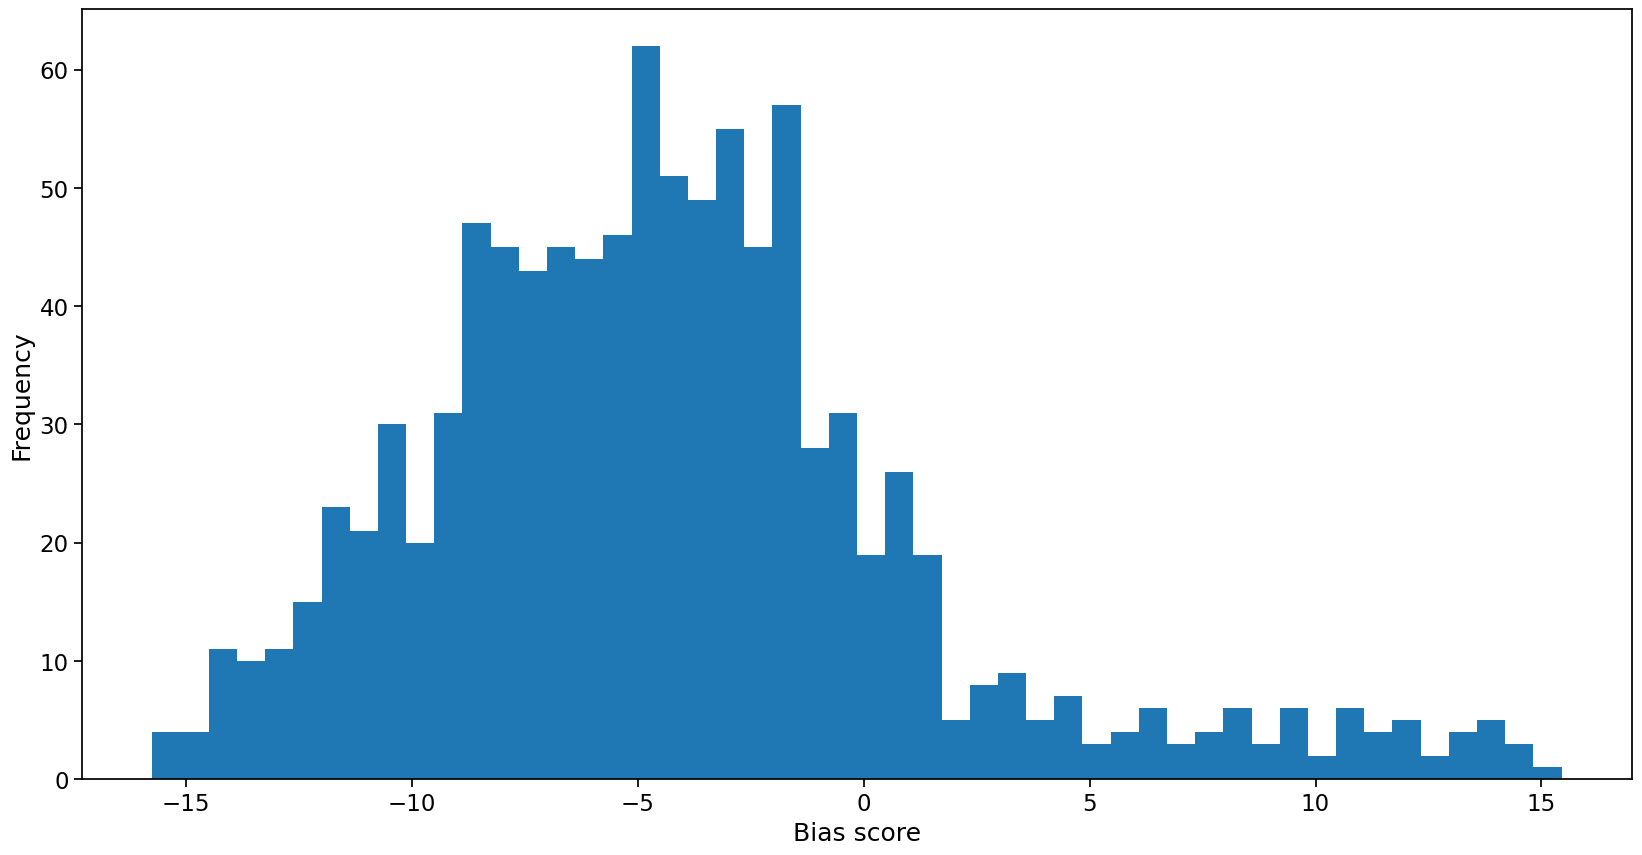

In [982]:
biasEval(X_test_nb, lstm_model, y_test_nb)

- Plot for bias scores: GloVe

42/42 [==============================] - 0s 8ms/step


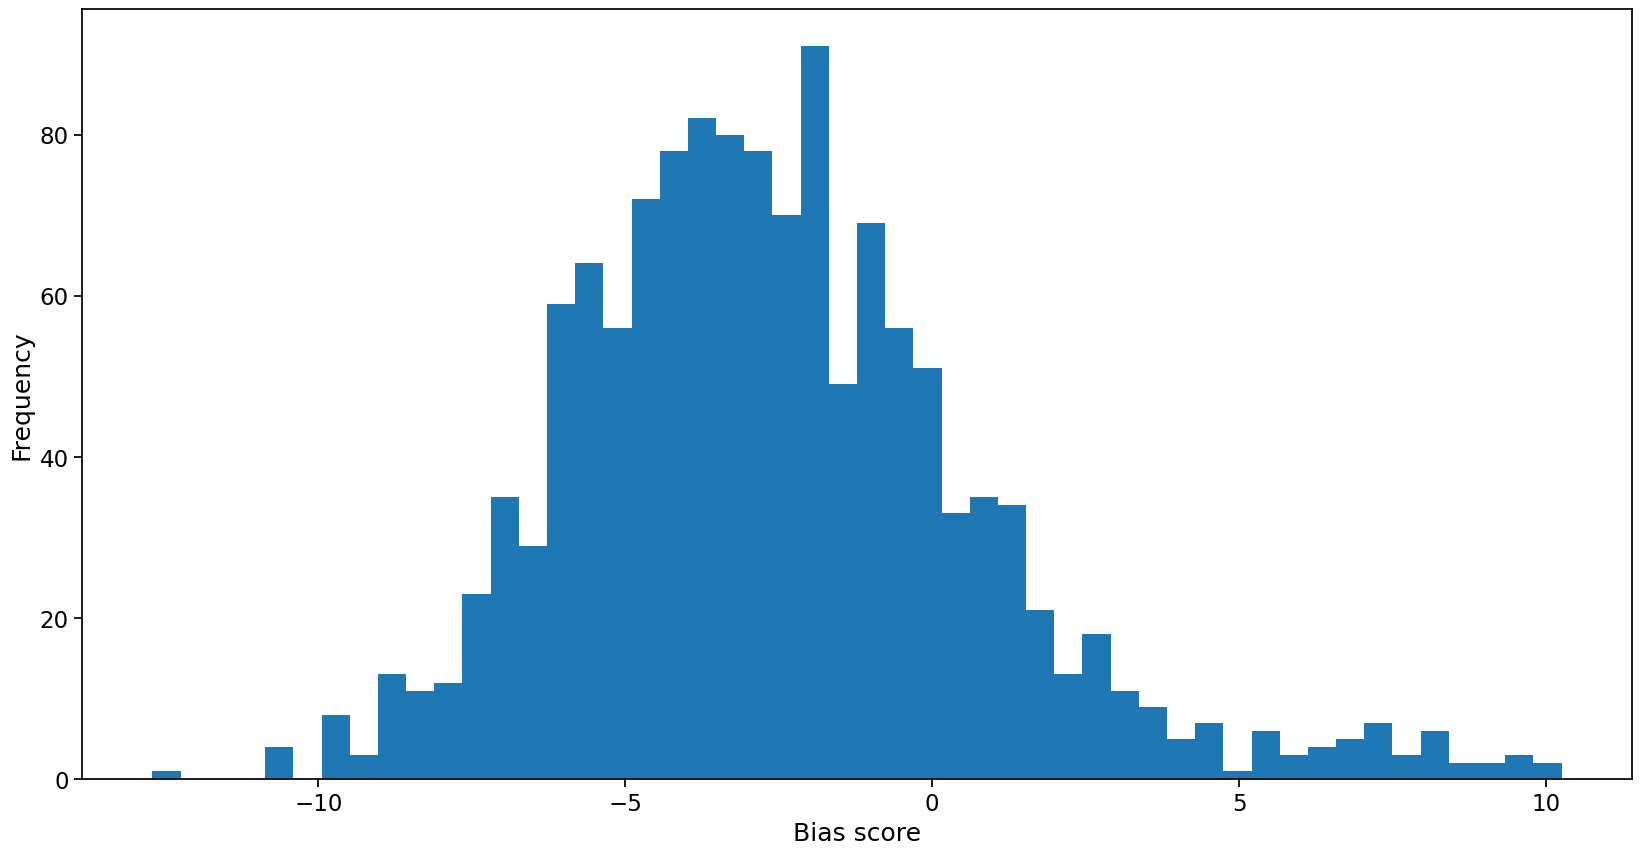

In [983]:
biasEval(X_test, lstm_numberbatch, y_test_ohe)

- concentration of the prediction for both appear to be on negative index implying bias towards prediction of certain words, numberbatch appear to be more concentrated between 0 to -5, while if we look while using glove embedding, we see that bias increases beyond it, with mean on -5.

- For a given input it shows classification the text and distribution of log probability across each labels.

In [1099]:
def word_predict(word: str, model):
    tokens = tokenizer.texts_to_sequences([word])
    padded_tokens = pad_sequences(tokens, maxlen=50)
    prediction = model.predict(padded_tokens)[0]
    y_pred_proba = np.squeeze(prediction)
    predicted_class = np.argmax(prediction)
    if predicted_class == 0:
        print(f"The text exhibit male polarity.{y_pred_proba}")
    elif predicted_class == 1:
        print(f"The text exhibit female polarity.{y_pred_proba}")
    else:
        print(f"text appear to be neutral.{y_pred_proba}")

In [1100]:
word_predict("programmer", lstm_numberbatch)

1/1 [==============================] - 0s 167ms/step
text appear to be neutral.[0.03584235 0.00661224 0.9575454 ]


In [1101]:
word_predict("programmer", lstm_model)

1/1 [==============================] - 0s 22ms/step
text appear to be neutral.[1.5314944e-03 2.3543064e-06 9.9846613e-01]


In [1102]:
word_predict("girl", lstm_model)

1/1 [==============================] - 0s 22ms/step
The text exhibit female polarity.[4.304714e-04 9.789900e-01 2.057949e-02]


In [1103]:
word_predict("girl", lstm_numberbatch)

1/1 [==============================] - 0s 21ms/step
text appear to be neutral.[0.01676325 0.00173452 0.98150223]


- This shows model was not able to exhibit certain bias or stereotype like attaching certain worlds like kitchen to woman and programmer to male. Above we find that girl was classified as female by lstm model using glove unlike numberbatch.

- Visualize: numberbatch LSTM model

(-10.0, 10.0)

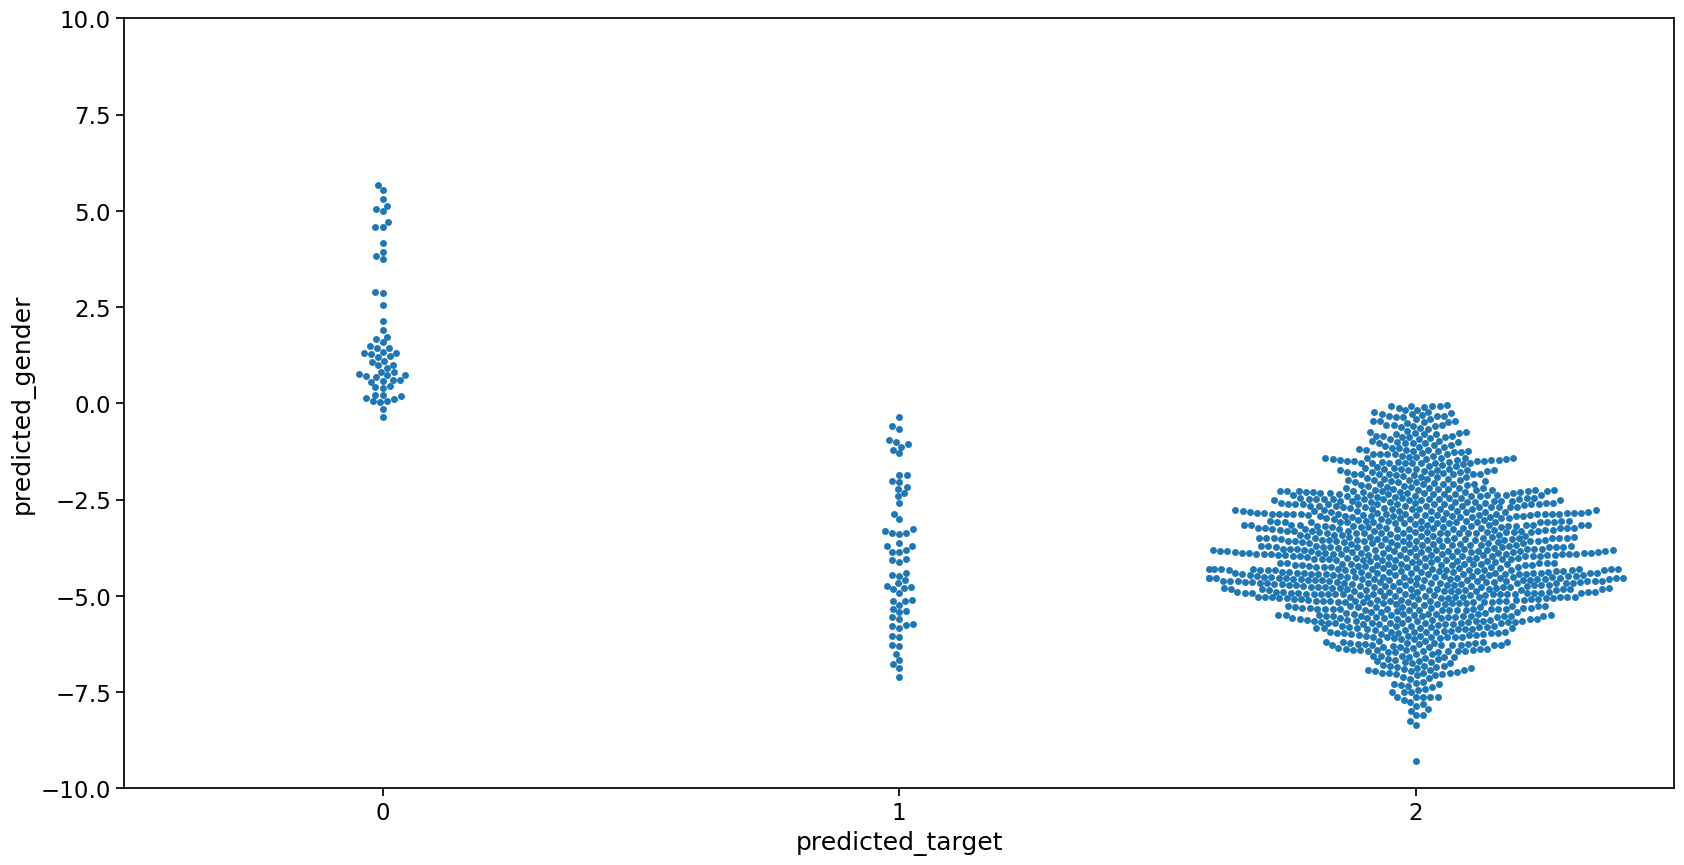

In [912]:
matplotlib.pyplot.figure(figsize=(20,10))
plot = seaborn.swarmplot(x='predicted_target', y='predicted_gender', data=results_df)
plot.set_ylim([-10, 10])

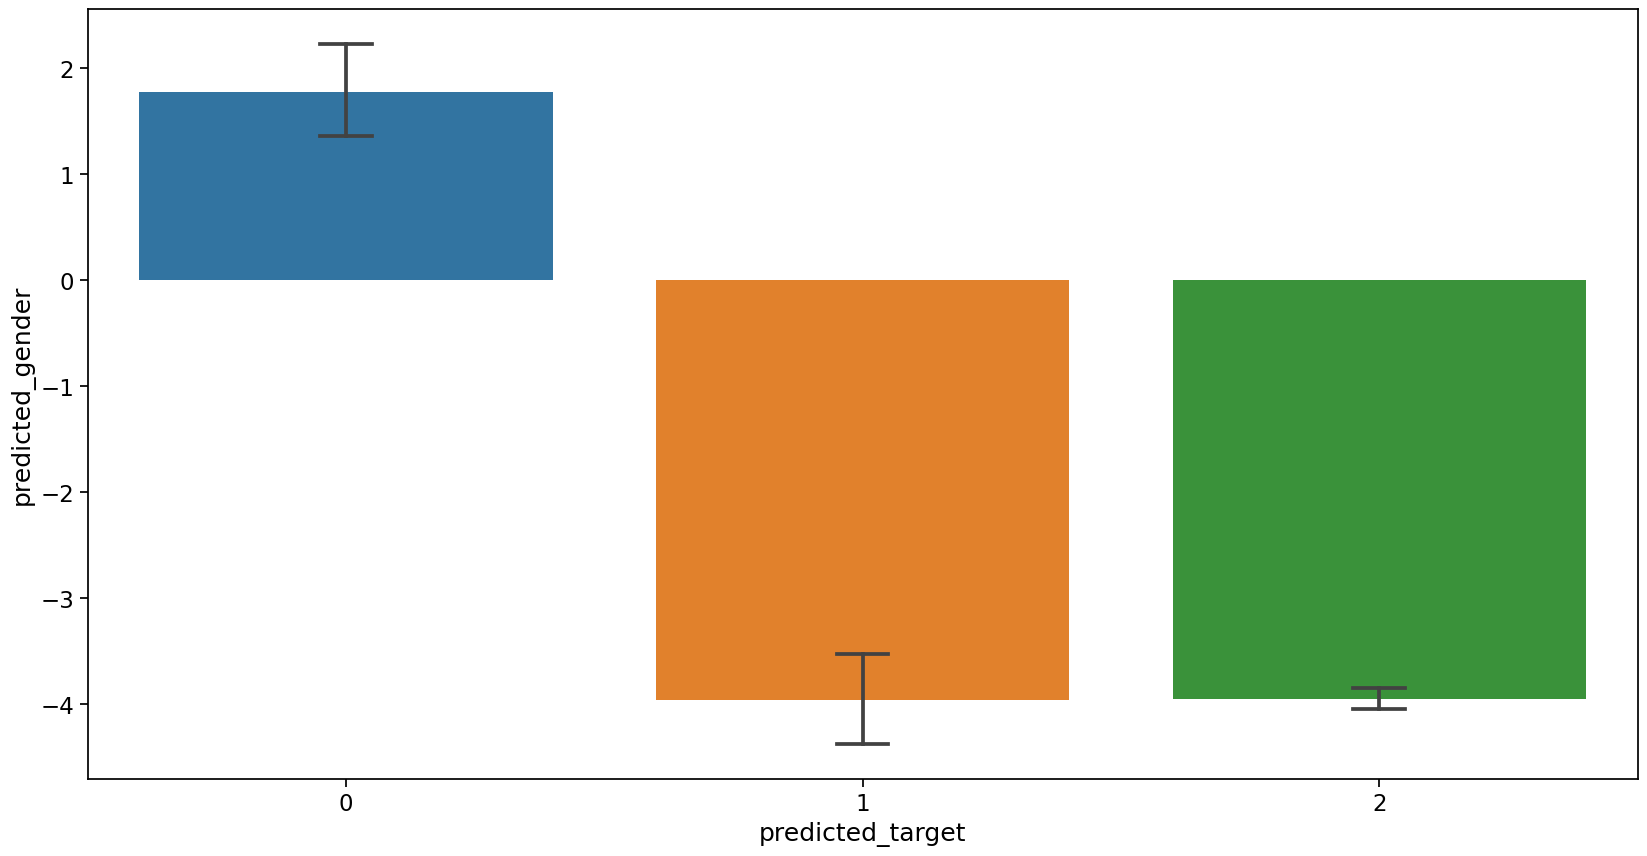

In [988]:
matplotlib.pyplot.figure(figsize=(20,10))
plot = seaborn.barplot(x='predicted_target', y='predicted_gender', data=results_df, capsize=.1)

- Visualize: GloVe LSTM model

(-10.0, 10.0)

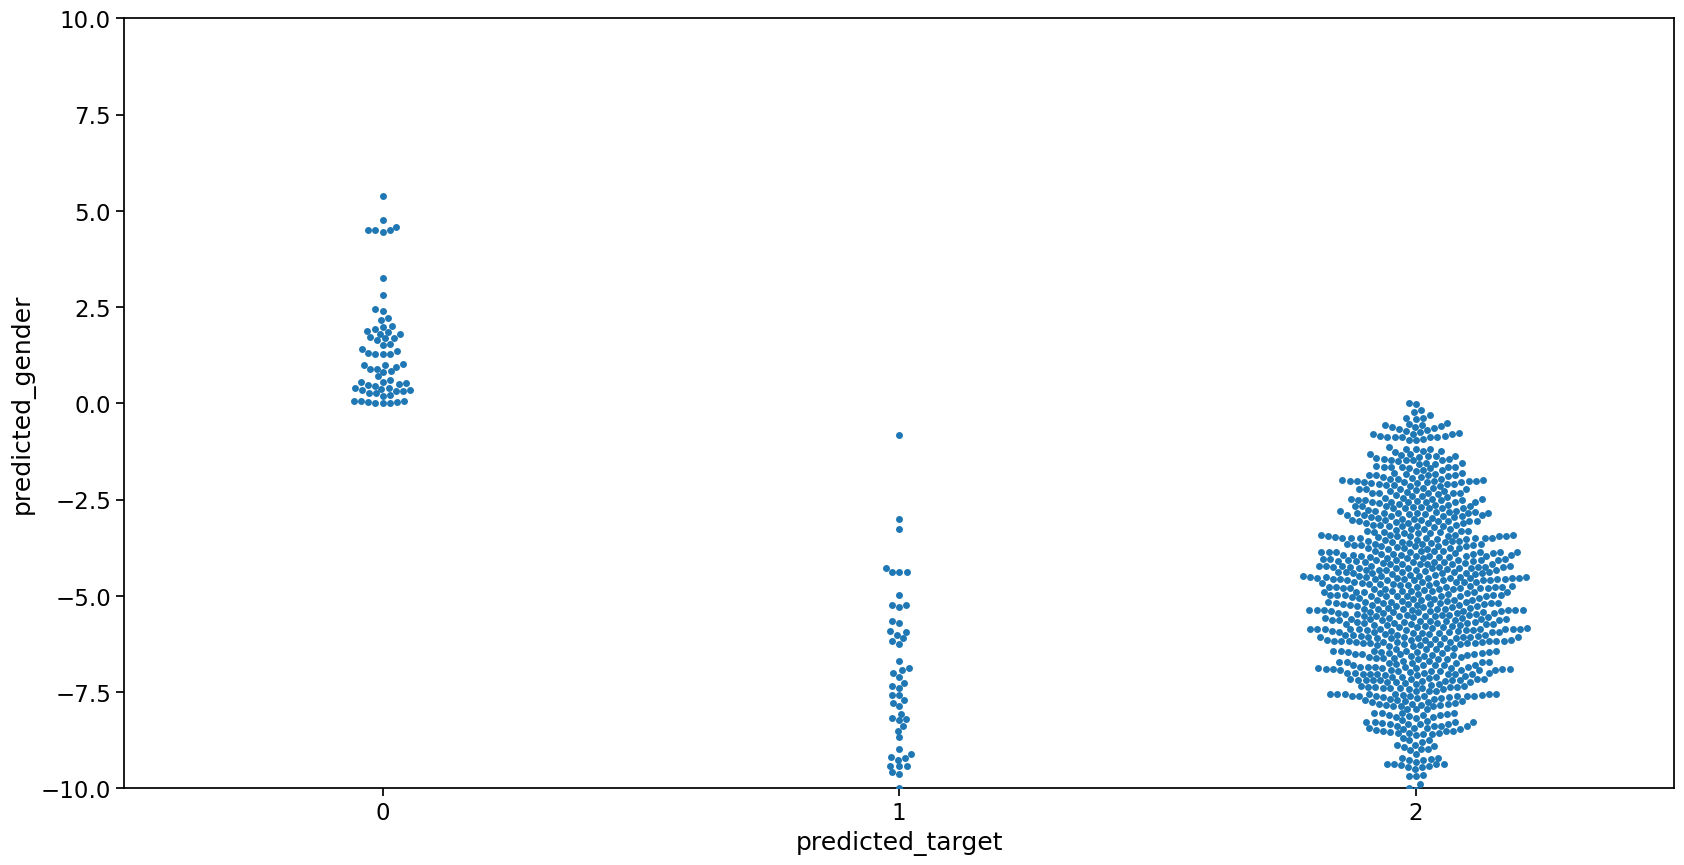

In [991]:
matplotlib.pyplot.figure(figsize=(20,10))
plot = seaborn.swarmplot(x='predicted_target', y='predicted_gender', data=results_glove)
plot.set_ylim([-10, 10])



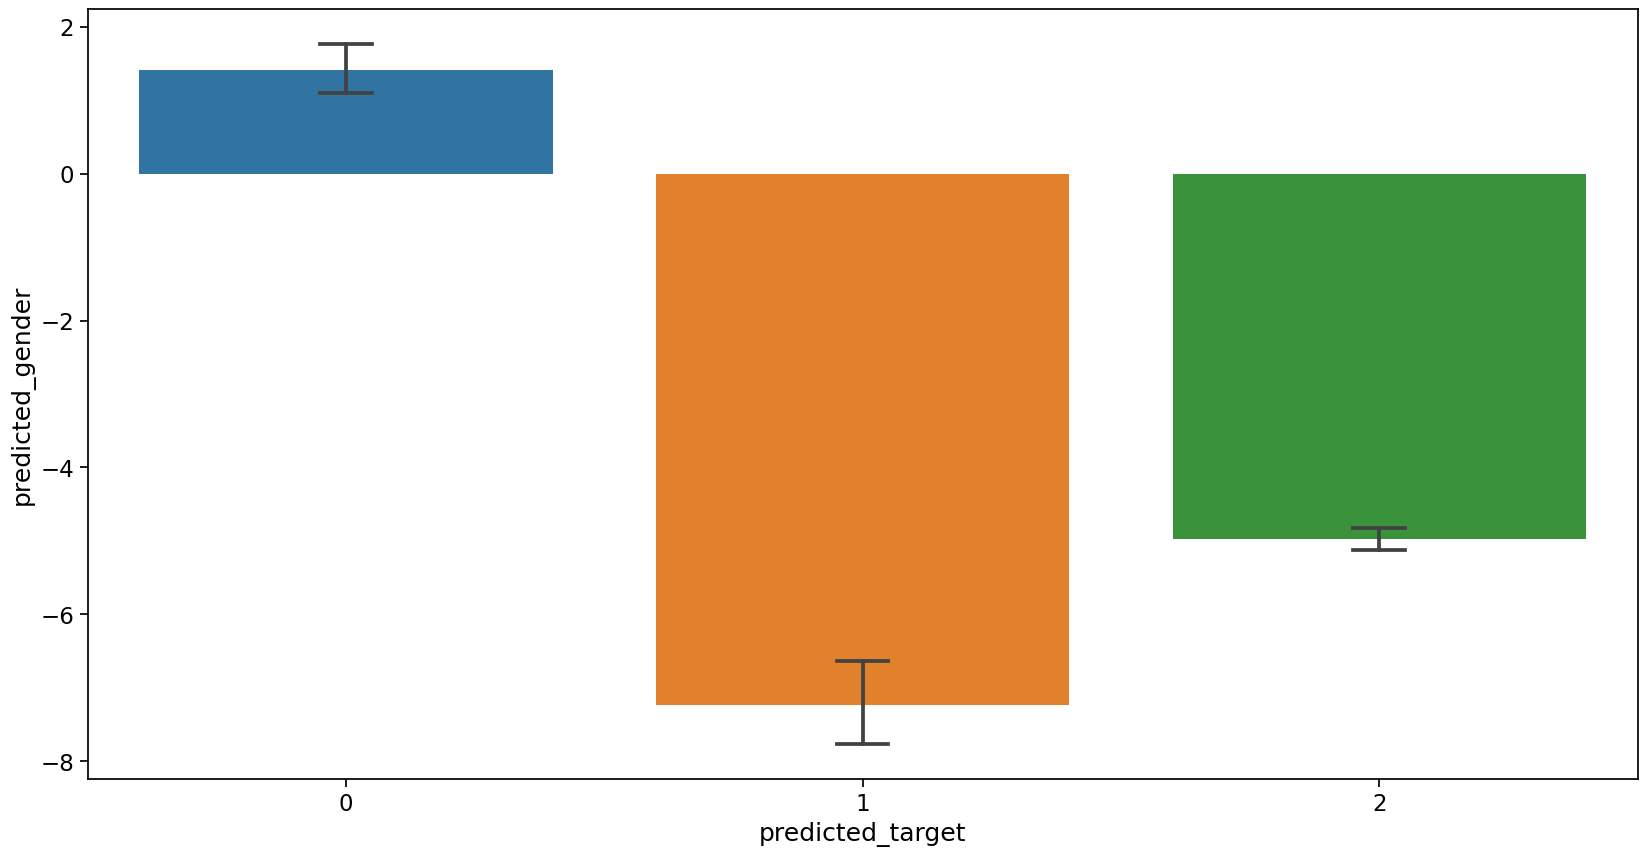

In [990]:
matplotlib.pyplot.figure(figsize=(20,10))
plot = seaborn.barplot(x='predicted_target', y='predicted_gender', data=results_glove, capsize=.1)

- There exist statistical difference between prediction of each class denoting bias, model appear to be bias towards neutral and female word after being trained on gendered data. Although both contain more neutral word more than male and female, lstm model using numberbatch show bias towards prediction of female label.Model could be tested to predict anology i.e. next word closer to it, where model predicts fourth word as mentioned in Bolukbasi et al. In ANOVA test, it does not tell us much about difference in the groups. It was task to get model that has large enteries to train model. There should be easiness of working with GPU's to enhance performances. It should also be noted that disimmilarity between number of input of each type of labels increases bias towards a class then it might be also important to feed unbiased data or it might impact a section of us in future.

- Lstm model is influenced from the below paper[a], while the LSTM using GloVe is based on [b], mostly hyperparameter were adjusted to need, however, model follows recommendation of using activation- softmax and loss-categorical_crossentropy. 
    - [a] Natural Language Processing for the Analysis Sentiment using a LSTM Model, Achraf BERRAJAA, International Journal of Advanced Computer Science and Applications, Vol. 13, No. 5, 2022.
    - [b] An Efficient Hybrid LSTM-CNN and CNN-LSTM with GloVe for Text Multi-class Sentiment Classification in Gender Violence, Abdul Azim Ismail1, IJACSA, Vol. 13, no. 9, 2022.

- Code are based from Dr. larson notebook https://github.com/8000net/LectureNotesMaster/blob/master/01%20ConceptNet.ipynb

- while other references fro the paper is provided below:

# reference

- 1- Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings, Bolukbasi, Tolga and Chang, Kai-Wei and Zou, James and Saligrama, Venkatesh and Kalai, Adam. https://doi.org/10.48550/arxiv.1607.06520
- 2- Tony Sun, Andrew Gaut, Shirlyn Tang, Yuxin Huang, Mai ElSherief, Jieyu Zhao, Diba Mirza, Elizabeth Belding, Kai-Wei Chang, and William Yang Wang. 2019. Mitigating Gender Bias in Natural Language Processing: Literature Review. In Proceedings of the 57th Annual Meeting of the Association for Computational Linguistics, pages 1630–1640, Florence, Italy. Association for Computational Linguistics.
- https://developers.googleblog.com/2018/04/text-embedding-models-contain-bias.html
- 3- Biased Embeddings from Wild Data: Measuring,Understanding and Removing https://arxiv.org/pdf/1806.06301.pdf

                                Thank you Professor